1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

### Импорты

In [ ]:
# Работа с папками и файлами
import os

# Работа со случайными числами
import random

# Работа с регулярными выражениями
import re

# Утилиты работы со временем
import time

# Отключение предупреждений
import warnings

# Работа с архивами
import zipfile

# Загрузка из google облака
import gdown

# Параметризация аудио
import librosa

# Отрисовка графиков
import matplotlib.pyplot as plt

# Массивы
import numpy as np

# Матрица ошибок классификатора
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import StandardScaler

# Основные слои
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling1D,
)

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

%matplotlib inline


### Загруузка и распаковк архивов данных

In [ ]:
if not os.path.exists("dataverse_files.zip"):
    # Загрузка файлов из Яндекс.Облака
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip",
        None,
        quiet=False,
    )
if not os.path.exists("archive.zip"):
    # Загрузка файлов из Яндекс.Облака
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip",
        None,
        quiet=False,
    )

In [4]:
# Распаковка архива на локальный диск
if not os.path.exists("tess"):
    with zipfile.ZipFile("dataverse_files.zip", "r") as zip_ref:
        zip_ref.extractall("tess")

if not os.path.exists("savee"):
    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall("savee")

print("tess:")
# Проверка выгруженных папок
print("\n".join(os.listdir("tess")[:10]))
print("\nsavee:")
# Проверка содержимого одной папки
print("\n".join(os.listdir("savee")))
print("\nsavee/ALL:")
print("\n".join(os.listdir("savee/ALL")[:10]))


tess:
OAF_read_sad.wav
OAF_gas_happy.wav
OAF_fit_happy.wav
OAF_juice_fear.wav
OAF_wife_disgust.wav
YAF_note_happy.wav
YAF_hurl_happy.wav
OAF_goal_angry.wav
YAF_king_happy.wav
OAF_bite_neutral.wav

savee:
ALL

savee/ALL:
JE_f07.wav
DC_sa14.wav
JK_sa06.wav
KL_su02.wav
JE_d02.wav
JK_sa01.wav
KL_d03.wav
JE_su15.wav
JE_su14.wav
JK_n28.wav


### Установка констант

In [ ]:
TESS_DIR = "./tess"  # Папка с аудио датасета TESS
SAVEE_DIR = "./savee/ALL"  # Папка с аудио датасета SAVEE

# Классы эмоций
CLASS_EMOTIONS = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
EMOTION_COUNT = len(CLASS_EMOTIONS)

# Соответствие эмоций и их кодов для датасета SAVEE
SAVEE_EMOTION_MAP = {
    "n": "neutral",
    "h": "happy",
    "sa": "sad",
    "a": "angry",
    "f": "fear",
    "d": "disgust",
    "su": "surprise",
}

In [ ]:
SR = 22050  # Частота дискретизации аудио
N_FFT = 2048  # Размер окна для преобразования Фурье
HOP_LENGTH = 512  # Шаг между окнами в преобразовании Фурье
SEQUENCE_DURATION_SEC = 2  # Длительность аудио последовательности в секундах
SEQUENCE_OVERLAP_SEC = 0.5  # Длительность перекрытия последовательностей в секундах

# Количество кадров в аудио последовательности
FRAMES_PER_SEQUENCE_SEGMENT = int(SR * SEQUENCE_DURATION_SEC / HOP_LENGTH)
# Количество кадров в перекрытии последовательностей
FRAMES_PER_OVERLAP_STEP = int(SR * SEQUENCE_OVERLAP_SEC / HOP_LENGTH)

### Функции для работы с аудиоданными

In [ ]:
def get_features(
    y,  # аудио сигнал
    sr,  # частота дискретизации аудио
    n_fft=N_FFT,  # размер окна для преобразования Фурье
    hop_length=HOP_LENGTH,  # шаг между окнами в преобразовании Фурье
):
    chroma_stft = librosa.feature.chroma_stft(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Хрома спектрограмма
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Мел-частотные кепстральные коэффициенты (MFCC)
    rmse = librosa.feature.rms(
        y=y, hop_length=hop_length
    )  # Корень среднеквадратического значения (RMS)
    spec_cent = librosa.feature.spectral_centroid(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Спектральный центр (спектральный центр тяжести)
    spec_bw = librosa.feature.spectral_bandwidth(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Спектральная полоса пропускания
    rolloff = librosa.feature.spectral_rolloff(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Спектральный роллофф
    zcr = librosa.feature.zero_crossing_rate(
        y, hop_length=hop_length
    )  # Коэффициент нулевых пересечений (ZCR)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Мел-спектрограмма

    poly_features = librosa.feature.poly_features(
        y=y, sr=sr, S=None, order=2
    )  # Полиномиальные признаки
    spec_contrast = librosa.feature.spectral_contrast(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )  # Спектральный контраст

    features = {
        "rmse": rmse,
        "spct": spec_cent,
        "spbw": spec_bw,
        "roff": rolloff,
        "zcr": zcr,
        "mfcc": mfcc,
        "stft": chroma_stft,
        "mel_spec": mel_spectrogram,
        "poly_feat": poly_features,
        "spec_cont": spec_contrast,
    }  # Собираем все признаки в словарь

    return features  # Возвращаем словарь признаков аудио сигнала


In [ ]:
def stack_features(feat):
    features = None  # Инициализация переменной для хранения стека признаков

    # Объединение всех признаков в один массив
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T  # Транспонируем массив признаков для удобства работы с ним


In [ ]:
def get_emotion_label_from_filename(filename, dataset_type="tess"):
    if dataset_type == "tess":  # Для датасета TESS
        parts = filename.split("_")  # Разделяем имя файла по символу "_"
        if len(parts) >= 3:
            emotion_raw = parts[-1].split(".")[
                0
            ]  # Извлекаем эмоцию из последней части имени файла
            # Если эмоция "ps" (surprise) в TESS, то возвращаем "surprise"
            if emotion_raw == "ps":
                return "surprise"
            return emotion_raw
    elif dataset_type == "savee":  # Для датасета SAVEE
        # Используем регулярное выражение для извлечения кода эмоции из имени файла
        match = re.match(r"[A-Z]{2}_([a-z]{1,2})\d{2}\.wav", filename)
        if match:
            emotion_code = match.group(1)  # Извлекаем код эмоции из совпадения
            return SAVEE_EMOTION_MAP.get(
                emotion_code
            )  # Возвращаем соответствующую эмоцию из словаря
    return None


In [ ]:
def get_feature_list_from_file(
    file_path,  # Путь к аудио файлу
    class_index,  # Индекс класса эмоции
    sequence_duration_frames,  # Количество кадров в последовательности
    overlap_frames,  # Количество кадров в перекрытии последовательностей
    SR=SR,  # Частота дискретизации аудио (по умолчанию 22050 Гц
):
    y, sr = librosa.load(file_path, mono=True, sr=SR)  # Загрузка аудио файла

    full_features = get_features(y, sr)  # Извлечение признаков аудио сигнала
    stacked_full_features = stack_features(
        full_features
    )  # Объединение признаков в один массив

    x_sequences = []  # Список для хранения последовательностей признаков
    y_labels = []  # Список для хранения меток классов в формате one-hot encoding

    # Преобразование метки класса в one-hot encoding
    y_label_one_hot = to_categorical(class_index, EMOTION_COUNT)

    num_frames = stacked_full_features.shape[0]  # Количество кадров в аудио сигнале

    if num_frames < sequence_duration_frames:
        # Если количество кадров меньше, чем длительность последовательности,
        # возвращаем пустые массивы
        return np.array([]).astype("float32"), np.array([]).astype("float32")

    for i in range(0, num_frames - sequence_duration_frames + 1, overlap_frames):
        # Извлечение последовательности признаков с учетом перекрытия
        sequence = stacked_full_features[i : i + sequence_duration_frames]
        x_sequences.append(sequence)
        y_labels.append(y_label_one_hot)
    # Преобразование списков в numpy массивы и приведение к типу float32
    return np.array(x_sequences).astype("float32"), np.array(y_labels).astype("float32")


In [ ]:
def extract_data_tess(
    base_dir=TESS_DIR,  # Папка с аудио датасетом TESS
    sequence_duration_frames=FRAMES_PER_SEQUENCE_SEGMENT,  # Количество кадров в аудио последовательности
    overlap_frames=FRAMES_PER_OVERLAP_STEP,  # Количество кадров в перекрытии последовательностей
):
    x_data = []  # Список для хранения аудио признаков
    y_data = []  # Список для хранения меток классов в формате one-hot encoding
    file_paths = []  # Список для хранения путей к аудио файлам

    curr_time = time.time()
    print(f"Извлечение признаков из TESS ({base_dir})...")

    for file in os.listdir(base_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(base_dir, file)  # Полный путь к аудио файлу

            # Извлечение метки эмоции из имени файла
            emotion_label = get_emotion_label_from_filename(file, dataset_type="tess")

            # Проверка, что метка эмоции не пустая и входит в список классов эмоций
            if emotion_label and emotion_label in CLASS_EMOTIONS:
                class_index = CLASS_EMOTIONS.index(emotion_label)

                # Извлечение признаков и меток классов из аудио файла
                file_x_sequences, file_y_labels = get_feature_list_from_file(
                    file_path, class_index, sequence_duration_frames, overlap_frames
                )

                if file_x_sequences.size > 0:
                    x_data.extend(file_x_sequences)
                    y_data.extend(file_y_labels)
                    file_paths.append(file_path)

    print(
        "Извлечение признаков из TESS завершено. "
        f"Обработано {len(file_paths)} файлов за {round(time.time() - curr_time)} с"
    )
    return np.array(x_data), np.array(
        y_data
    )  # Возвращаем массивы признаков и меток классов


### Работа с данными и создание выборок

In [ ]:
print("Извлечение признаков из датасета TESS ...")
x_data_tess, y_data_tess = (
    extract_data_tess()
)  # Извлечение признаков и меток классов из TESS
print(f"Размерность данных X из TESS: {x_data_tess.shape}")
print(f"Размерность данных Y из TESS: {y_data_tess.shape}")

Извлечение признаков из датасета TESS ...
Извлечение признаков из TESS (./tess)...
Извлечение признаков из TESS завершено. Обработано 1684 файлов за 103 с
Размерность данных X из TESS: (2020, 86, 175)
Размерность данных Y из TESS: (2020, 7)


In [ ]:
print("Нормирование признаков...")
original_shape_tess = x_data_tess.shape  # Сохраняем оригинальную форму данных

# Приводим данные к двумерному виду для нормализации
x_data_tess_reshaped = x_data_tess.reshape(-1, original_shape_tess[-1])

x_scaler_emotion = StandardScaler()  # Инициализация скейлера для нормализации признаков
x_data_tess_scaled = x_scaler_emotion.fit_transform(x_data_tess_reshaped)

# Приводим данные обратно к исходной форме
x_data_tess_scaled = x_data_tess_scaled.reshape(original_shape_tess)
print("Нормирование завершено.")


Нормирование признаков...
Нормирование завершено.


In [ ]:
TEST_SPLIT_RATIO = 0.2  # Доля тестовой выборки
x_train_emotion, x_test_emotion, y_train_emotion, y_test_emotion = train_test_split(
    x_data_tess_scaled,
    y_data_tess,
    test_size=TEST_SPLIT_RATIO,
    stratify=y_data_tess,
    random_state=42,
)  # Разделение данных на обучающую и тестовую выборки

print(f"Размер обучающей выборки X: {x_train_emotion.shape}")
print(f"Размер обучающей выборки Y: {y_train_emotion.shape}")
print(f"Размер тестовой выборки X: {x_test_emotion.shape}")
print(f"Размер тестовой выборки Y: {y_test_emotion.shape}")


Размер обучающей выборки X: (1616, 86, 175)
Размер обучающей выборки Y: (1616, 7)
Размер тестовой выборки X: (404, 86, 175)
Размер тестовой выборки Y: (404, 7)


### Вспомогательные функции

In [ ]:
def show_history(history):  # Функция для отображения истории обучения модели
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()


In [ ]:
def classify_emotion_file(
    model,  # обученная модель классификатора
    x_scaler,  # настроенный нормировщик входных данных
    file_path,  # полный путь к аудиофайлу
    true_emotion_label,  # верная текстовая метка эмоции
    sequence_duration_frames=FRAMES_PER_SEQUENCE_SEGMENT,  # количество кадров в аудио последовательности
    overlap_frames=FRAMES_PER_OVERLAP_STEP,  # количество кадров в перекрытии последовательностей
):  # Функция для классификации эмоции в аудиофайле
    true_class_index = CLASS_EMOTIONS.index(true_emotion_label)

    # Получаем последовательности признаков из файла
    file_x_sequences, _ = get_feature_list_from_file(
        file_path, true_class_index, sequence_duration_frames, overlap_frames
    )

    if file_x_sequences.size == 0:
        print(f"Файл {os.path.basename(file_path)} слишком короткий для обработки.")
        return -1

    # Нормирование признаков уже настроенным нормировщиком
    original_file_shape = file_x_sequences.shape
    file_x_sequences_reshaped = file_x_sequences.reshape(-1, original_file_shape[-1])
    file_x_sequences_scaled = x_scaler.transform(file_x_sequences_reshaped)
    file_x_sequences_scaled = file_x_sequences_scaled.reshape(original_file_shape)

    print("Файл:", os.path.basename(file_path))
    print("Истинная эмоция:", true_emotion_label)
    print(
        "Количество последовательностей для предсказания:",
        file_x_sequences_scaled.shape[0],
    )

    # Вычисление предсказания по всем последовательностям из файла
    predict = model.predict(file_x_sequences_scaled, verbose=0)
    # Определение среднего предсказания (голосование) по всем последовательностям
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    predict_emotion_label = CLASS_EMOTIONS[predict_class_index]
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == true_class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10, 3))
    print(
        "Классификация сети:",
        predict_emotion_label,
        "-",
        "ВЕРНО :-)" if predict_good else "НЕВЕРНО.",
    )
    plt.title(f"Предсказание для {os.path.basename(file_path)}")
    plt.bar(CLASS_EMOTIONS, predict_mean, color="g" if predict_good else "r")
    plt.ylim(0, 1)  # Нормализуем ось Y для вероятностей
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    print("---------------------------------------------------------------")

    return predict_class_index


In [ ]:
def classify_test_files_emotion(
    model,  # обученная модель классификатора
    x_scaler,  # настроенный нормировщик входных данных
    audio_files_list,  # список полных путей к файлам для теста
    dataset_type,  # тип датасета ("tess" или "savee")
    n_files_to_show=5,  # количество файлов для детальной классификации (0 - не показывать)
):
    predict_all = 0  # Общее количество предсказаний
    predict_good = 0  # Количество верных предсказаний
    y_true = []  # Список истинных меток классов
    y_pred = []  # Список предсказанных меток классов

    displayed_emotions = {
        emotion: False for emotion in CLASS_EMOTIONS
    }  # Словарь для отслеживания отображенных эмоций

    print(f"\nКлассификация на {dataset_type.upper()} датасете...")

    for file_path in audio_files_list:
        # Получаем имя файла и истинную метку эмоции
        filename = os.path.basename(file_path)
        true_emotion_label = get_emotion_label_from_filename(filename, dataset_type)

        if true_emotion_label not in CLASS_EMOTIONS:
            continue

        true_class_index = CLASS_EMOTIONS.index(
            true_emotion_label
        )  # Индекс истинного класса

        file_x_sequences, _ = get_feature_list_from_file(
            file_path,
            true_class_index,
            FRAMES_PER_SEQUENCE_SEGMENT,
            FRAMES_PER_OVERLAP_STEP,
        )  # Извлечение признаков из файла

        if file_x_sequences.size == 0:
            continue

        # Нормирование признаков
        original_file_shape = file_x_sequences.shape
        file_x_sequences_reshaped = file_x_sequences.reshape(
            -1, original_file_shape[-1]
        )
        # Применение нормализации с помощью уже обученного скейлера
        file_x_sequences_scaled = x_scaler.transform(file_x_sequences_reshaped)
        file_x_sequences_scaled = file_x_sequences_scaled.reshape(original_file_shape)

        # Предсказание
        predict = model.predict(file_x_sequences_scaled, verbose=0)
        predict_mean = predict.mean(axis=0)
        predict_class_index = np.argmax(predict_mean)

        y_true.append(true_class_index)
        y_pred.append(predict_class_index)
        predict_all += 1
        predict_good += predict_class_index == true_class_index

        # Если нужно показать детально, и для этой эмоции еще не показывали
        if n_files_to_show > 0 and not displayed_emotions[true_emotion_label]:
            print(f"\nДетальная классификация для {filename}:")
            classify_emotion_file(model, x_scaler, file_path, true_emotion_label)
            displayed_emotions[true_emotion_label] = True
            n_files_to_show -= 1

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100.0, 2)
    print(
        f"=== Обработано образцов: {predict_all}, "
        f"из них распознано верно: {predict_good}, доля верных: {good_ratio}% ==="
    )

    # Построение матрицы ошибок
    cm = confusion_matrix(y_true, y_pred, labels=range(EMOTION_COUNT))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f"Матрица ошибок для {dataset_type.upper()} датасета")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_EMOTIONS)
    disp.plot(ax=ax, cmap=plt.cm.Blues)  # Используем синюю цветовую схему
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Отчет по классификации (точность, полнота, F1-мера)
    print("\nОтчет по классификации:")
    print(
        classification_report(
            y_true, y_pred, labels=range(EMOTION_COUNT), target_names=CLASS_EMOTIONS
        )
    )


### Созздание и обучение модели

In [ ]:
model_emotion = Sequential(
    [
        Input(
            shape=(x_train_emotion.shape[1], x_train_emotion.shape[2])
        ),  # Входной слой
        # Первый сверточный блок
        Conv1D(filters=128, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        # Второй сверточный блок
        Conv1D(filters=256, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        # Третий сверточный блок
        Conv1D(filters=512, kernel_size=3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        # Полносвязный блок
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(EMOTION_COUNT, activation="softmax"),
    ]
)


In [ ]:
model_emotion.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)  # Компиляция модели
model_emotion.summary()  # Вывод структуры модели


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 84, 128)        │        67,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,744,903 (6.66 MB)

 Trainable params: 1,743,111 (6.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.2428 - loss: 3.2463 - val_accuracy: 0.2054 - val_loss: 1.7920
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5793 - loss: 1.3232 - val_accuracy: 0.7896 - val_loss: 1.1995
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7390 - loss: 0.8576 - val_accuracy: 0.9035 - val_loss: 0.7692
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8207 - loss: 0.5703 - val_accuracy: 0.9455 - val_loss: 0.4740
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8569 - loss: 0.4656 - val_accuracy: 0.9703 - val_loss: 0.3035
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8927 - loss: 0.3352 - val_accuracy: 0.9703 - val_loss: 0.1994
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9128 - loss: 0.3087 - val_accuracy: 0.9703 - val_loss: 0.1358
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9192 - loss: 0.3110 - val_accuracy: 0.9851 

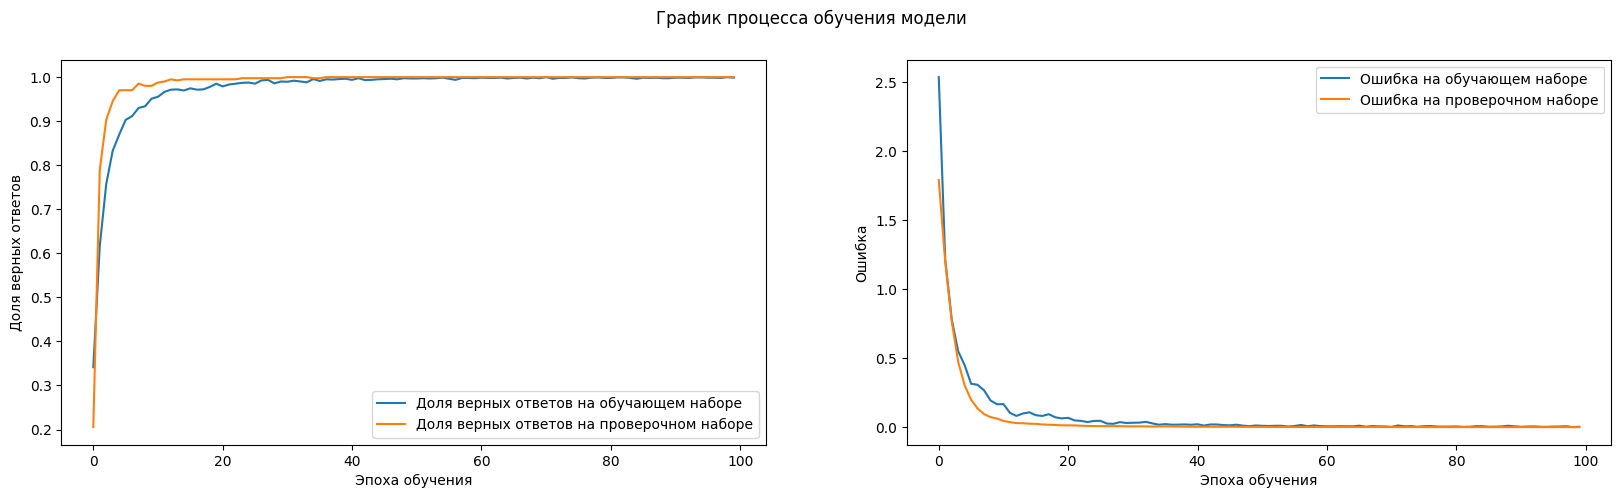

In [ ]:
history_emotion = model_emotion.fit(
    x_train_emotion,
    y_train_emotion,
    epochs=100,
    batch_size=64,
    validation_data=(x_test_emotion, y_test_emotion),
    verbose=1,
)  # Обучение модели

show_history(history_emotion)  # Отображение истории обучения модели


### Оценка модели

In [25]:
print("\nОценка модели на тестовой выборке TESS:")
loss, accuracy = model_emotion.evaluate(x_test_emotion, y_test_emotion, verbose=0)
print(f"Точность на тестовой выборке TESS: {accuracy * 100:.2f}%")



Оценка модели на тестовой выборке TESS:
Точность на тестовой выборке TESS: 100.00%



Классификация на TESS датасете...
=== Обработано образцов: 1684, из них распознано верно: 1684, доля верных: 100.0% ===


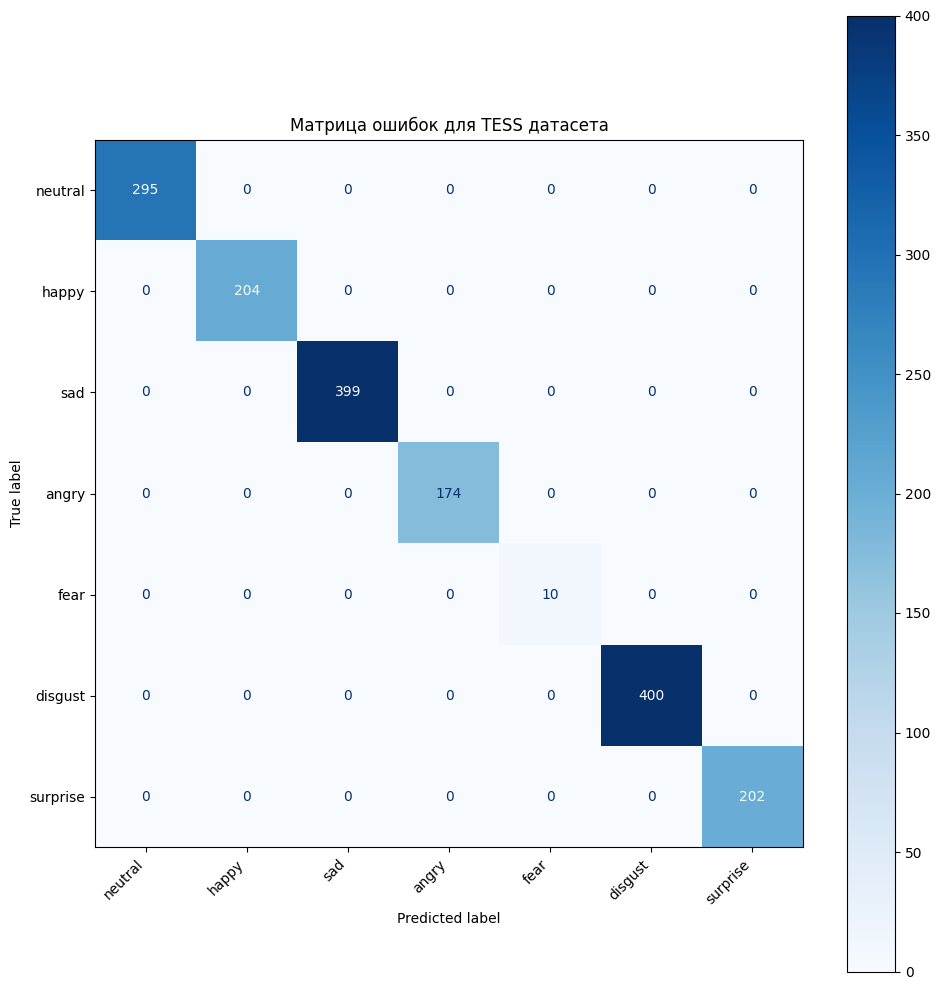


Отчет по классификации:
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00       295
       happy       1.00      1.00      1.00       204
         sad       1.00      1.00      1.00       399
       angry       1.00      1.00      1.00       174
        fear       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00       400
    surprise       1.00      1.00      1.00       202

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684



In [ ]:
all_tess_files = [
    os.path.join(TESS_DIR, f) for f in os.listdir(TESS_DIR) if f.endswith(".wav")
]  # Список всех аудио файлов в TESS
classify_test_files_emotion(
    model_emotion,
    x_scaler_emotion,
    audio_files_list=all_tess_files,
    dataset_type="tess",
    n_files_to_show=0,
)  # Классификация всех файлов в TESS без детальной визуализации



Проверка классификатора на датасете SAVEE (детальные графики для нескольких файлов):

Классификация на SAVEE датасете...

Детальная классификация для DC_n24.wav:
Файл: DC_n24.wav
Истинная эмоция: neutral
Количество последовательностей для предсказания: 4
Классификация сети: sad - НЕВЕРНО.


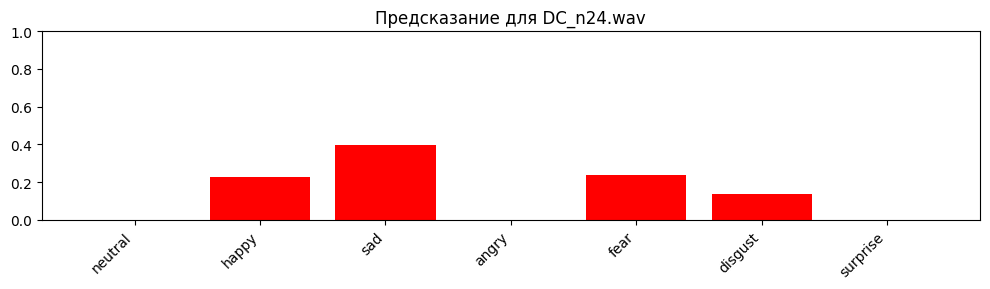

---------------------------------------------------------------

Детальная классификация для JE_sa11.wav:
Файл: JE_sa11.wav
Истинная эмоция: sad
Количество последовательностей для предсказания: 9
Классификация сети: sad - ВЕРНО :-)


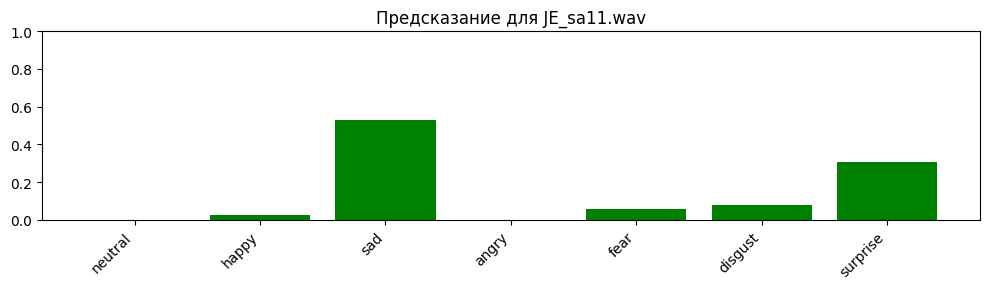

---------------------------------------------------------------

Детальная классификация для JE_d03.wav:
Файл: JE_d03.wav
Истинная эмоция: disgust
Количество последовательностей для предсказания: 2
Классификация сети: sad - НЕВЕРНО.


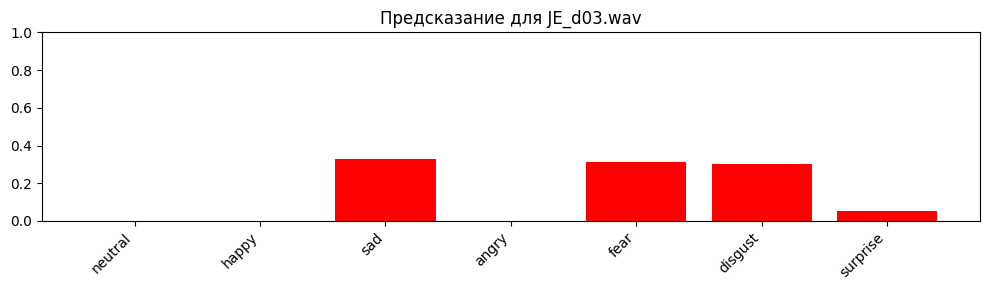

---------------------------------------------------------------

Детальная классификация для DC_h01.wav:
Файл: DC_h01.wav
Истинная эмоция: happy
Количество последовательностей для предсказания: 4
Классификация сети: fear - НЕВЕРНО.


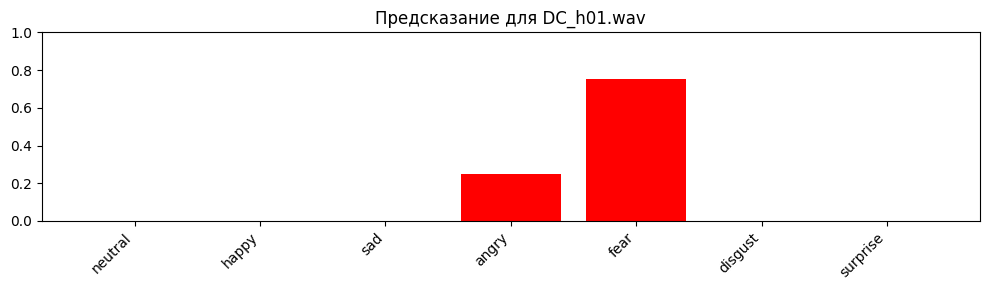

---------------------------------------------------------------

Детальная классификация для KL_f01.wav:
Файл: KL_f01.wav
Истинная эмоция: fear
Количество последовательностей для предсказания: 5
Классификация сети: disgust - НЕВЕРНО.


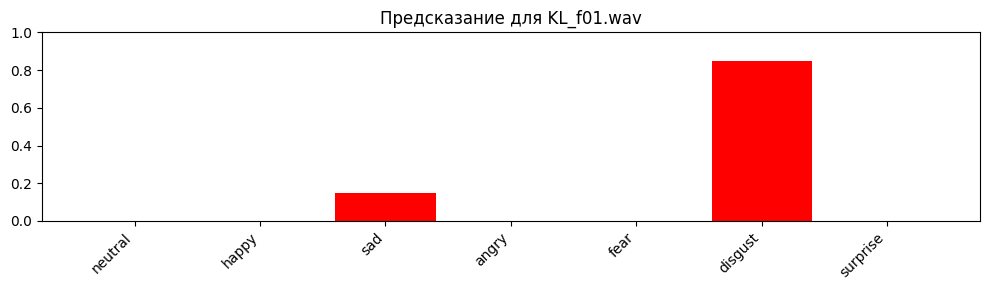

---------------------------------------------------------------

Детальная классификация для KL_a05.wav:
Файл: KL_a05.wav
Истинная эмоция: angry
Количество последовательностей для предсказания: 3
Классификация сети: disgust - НЕВЕРНО.


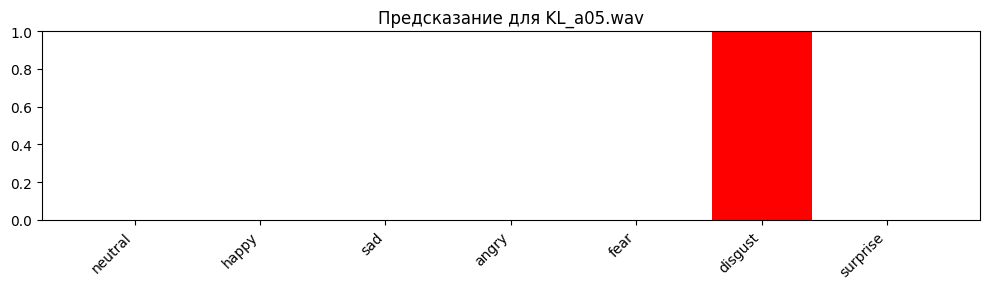

---------------------------------------------------------------
=== Обработано образцов: 7, из них распознано верно: 1, доля верных: 14.29% ===


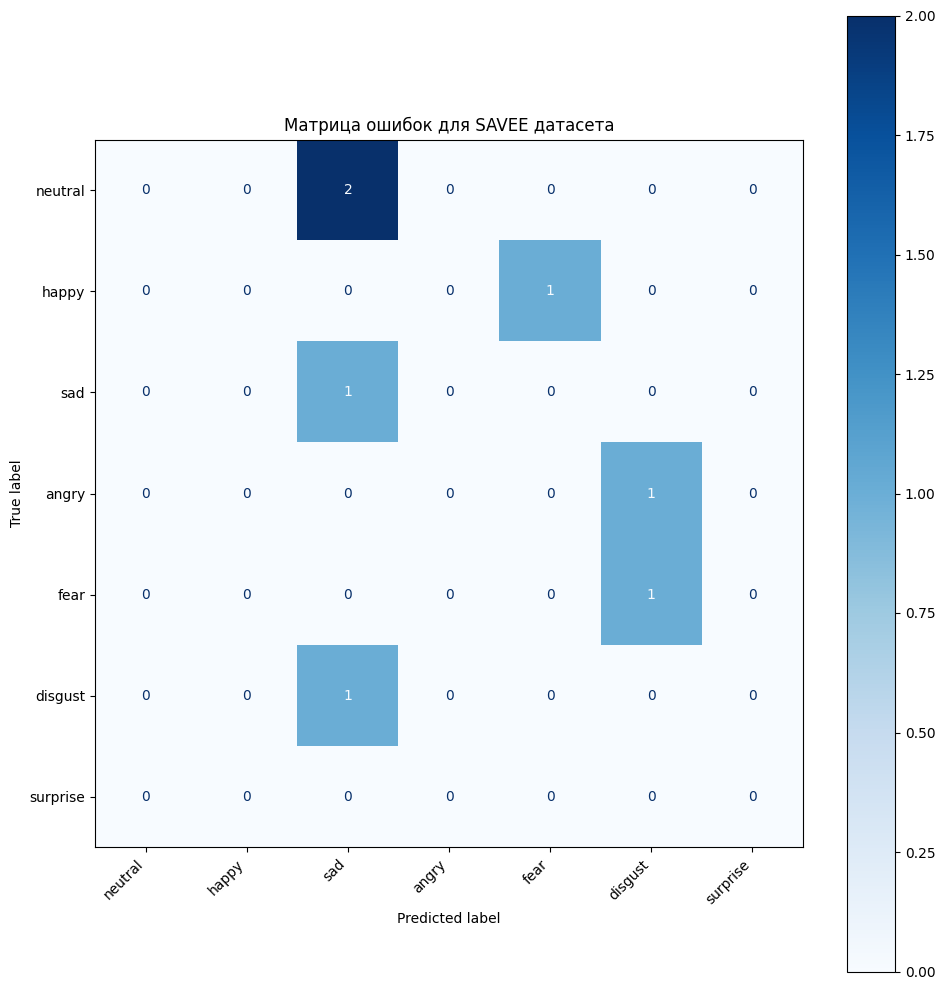


Отчет по классификации:
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00         2
       happy       0.00      0.00      0.00         1
         sad       0.25      1.00      0.40         1
       angry       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         1
     disgust       0.00      0.00      0.00         1
    surprise       0.00      0.00      0.00         0

    accuracy                           0.14         7
   macro avg       0.04      0.14      0.06         7
weighted avg       0.04      0.14      0.06         7


Полная оценка на датасете SAVEE:

Классификация на SAVEE датасете...
=== Обработано образцов: 467, из них распознано верно: 79, доля верных: 16.92% ===


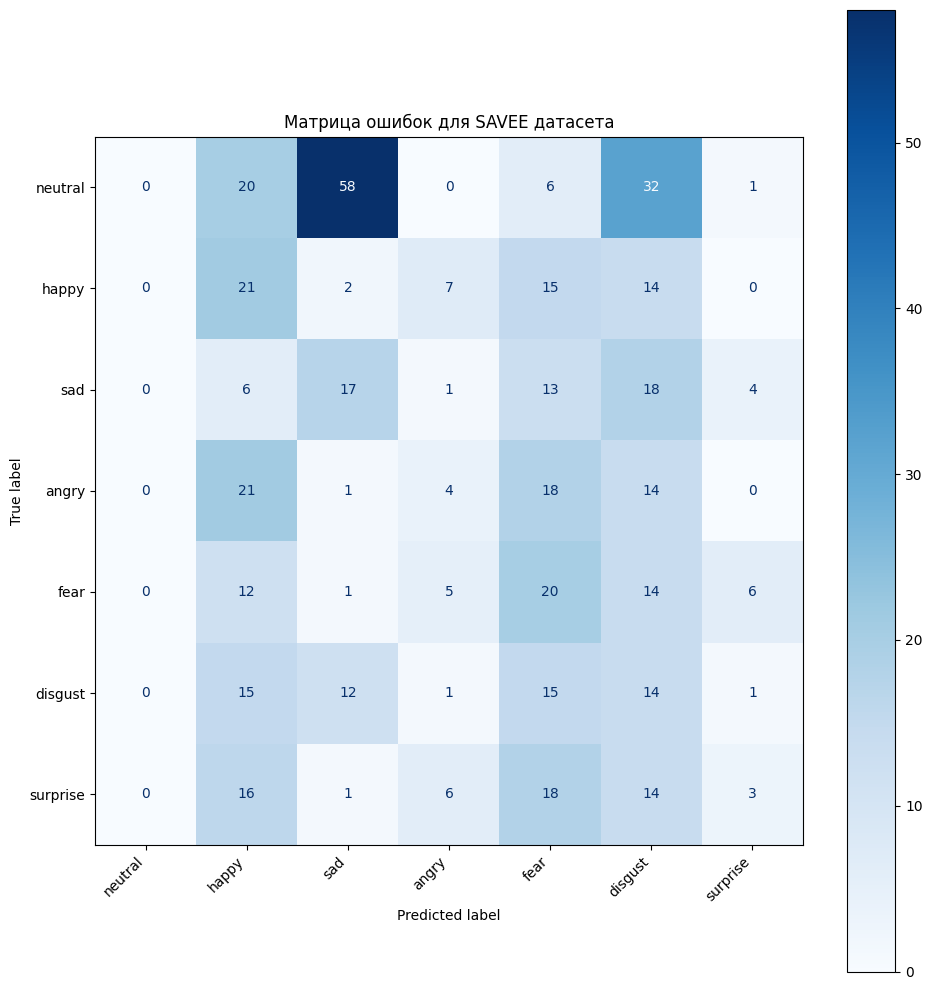


Отчет по классификации:
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       117
       happy       0.19      0.36      0.25        59
         sad       0.18      0.29      0.23        59
       angry       0.17      0.07      0.10        58
        fear       0.19      0.34      0.25        58
     disgust       0.12      0.24      0.16        58
    surprise       0.20      0.05      0.08        58

    accuracy                           0.17       467
   macro avg       0.15      0.19      0.15       467
weighted avg       0.13      0.17      0.13       467



In [ ]:
savee_audio_files = []  # Список для хранения аудио файлов из датасета SAVEE
for file in os.listdir(SAVEE_DIR):
    if file.endswith(".wav"):
        # Проверяем, что файл соответствует формату SAVEE
        savee_audio_files.append(os.path.join(SAVEE_DIR, file))


random.seed(42)
random_savee_files = random.sample(savee_audio_files, min(7, len(savee_audio_files)))

print(
    "\nПроверка классификатора на датасете SAVEE (детальные графики для нескольких файлов):"
)
classify_test_files_emotion(
    model_emotion,
    x_scaler_emotion,
    random_savee_files,
    dataset_type="savee",
    n_files_to_show=len(CLASS_EMOTIONS),
)  # Классификация случайных файлов из SAVEE с детальной визуализацией

print("\nПолная оценка на датасете SAVEE:")
classify_test_files_emotion(
    model_emotion,
    x_scaler_emotion,
    savee_audio_files,
    dataset_type="savee",
    n_files_to_show=0,
)  # Классификация всех файлов в SAVEE без детальной визуализации
